# V‑JEPA 2‑AC — Tutorial

**Goal:** Make it easy to plug in a dataset and:
- Understand **inputs** (images, state, actions)
- Run **teacher-forcing** and **open‑loop** predictions
- **Decode** tokens back to images
- Save clean **GT vs Pred** videos with **automatic naming**

---

## Table of contents
1. [Overview](#overview)
2. [Inputs](#inputs)
   - [Images → Tokens](#images--tokens)
   - [State (7‑D)](#state-7-d)
   - [Actions (Δ‑state)](#actions-Δ-state)
3. [Encode → Predict → Decode](#encode--predict--decode)
4. [Decoder](#decoder)
5. [Evaluation modes](#evaluation-modes)
6. [Shapes quick‑reference](#shapes-quick-reference)
7. [Time alignment](#time-alignment)
8. [Normalization & units](#normalization--units)
9. [Minimal end‑to‑end example](#minimal-end-to-end-example)
10. [Troubleshooting](#troubleshooting)

---

## Overview

V‑JEPA 2‑AC is an **action‑conditioned latent world model**. At step **t** it takes:

- **Tokens** for the current frame `z_t` (obtained by encoding an RGB image),
- The robot **state** `s_t` (7‑D pose + gripper),
- An **action** `a_t` (typically the *delta* from `s_t` to `s_{t+1}`),

…and predicts **next‑step tokens** `z_{t+1}` (which you can **decode** back to an image) and an updated state `s_{t+1}`.

---

## Inputs

### Images → Tokens

- Two consecutive RGB images, ~4 FPS apart.
- Each image is `uint8` **[H, W, 3]**, resized to **256×256**.
- Before encoding, build a tensor of shape **[1, 3, 2, 256, 256]** = `[Batch, Channels, Time, Height, Width]` and normalize to **[0,1]**.

> The AC encoder expects **T=2**. If you only have one frame, **duplicate** it along the time axis.

**Encode one 256×256 image to tokens (PyTorch):**
- `Ts²` (**tokens/frame**) = `(256 / patch_size)²` (e.g., 256 if `patch_size=16`).
- `D` = token **embedding dim** (e.g., 1408 for ViT‑Giant).

### State (7‑D)

A compact end‑effector state at time **t**:

| Index | Name               | Units   | Description                         |
|-----:|--------------------|---------|-------------------------------------|
| 0–2  | `x, y, z`          | meters  | EE position in base frame           |
| 3–5  | `roll, pitch, yaw` | radians | EE orientation (Euler `xyz`)        |
| 6    | `gripper`          | –       | Openness (dataset‑specific scaling) |

**Convert `(x,y,z,qx,qy,qz,qw,gripper)` → 7‑D:**


> ⚠️ Euler wrap (near ±π) can cause jumps; for robust deltas, consider quaternion‑based rotation deltas.

### Actions (Δ‑state)

Default: **7‑D deltas** between consecutive states:
```python
def action_delta(t):
    return (ee7_t[t+1] - ee7_t[t]).view(1,1,7)  # [1,1,7]
```

Optional **quaternion‑safe** orientation deltas (axis‑angle) are provided in the Troubleshooting section.

---

## Encode → Predict → Decode

**Predict next tokens** given current tokens, action, and state:

## Decoder

Your `TokenDecoder` maps a token grid `[B, N, D]` (with `N=Ts²`) back to an RGB image `[B,3,256,256]` using a 1×1 projection plus a stack of learned upsampling blocks (e.g., ConvTranspose or Upsample+Conv), ending with a 3‑channel head and `Sigmoid`.

Key contracts:
- Input tokens must reshape to a square grid: `N = Ts × Ts`.
- `embed_dim` must match the encoder’s token dimension `D`.
- Final spatial size must be **256×256** to match training/eval.  

---

## Evaluation modes

### A) Teacher‑forcing
At each step you feed **ground‑truth tokens** `z_t` (and **GT action** `a_t`) to predict `z_{t+1}`, then decode and compare vs the GT image at `t+1`.
- Pros: tests single‑step accuracy.
- Cons: doesn’t test rollouts.

### B) Open loop
Encode only at the **start**. Then **roll** predictions: feed `(ẑ_t, a_t, ŝ_t)` → `ẑ_{t+1}`, decode, and continue.
- Pros: tests temporal stability.
- Cons: errors accumulate; harder.

Both modes can be visualized as **GT | Predicted** side‑by‑side videos with automatic filenames.

---

## Shapes quick‑reference

- **Encoder input (clip)**: `[1, 3, 2, 256, 256]`
- **Tokens per frame**: `Ts² = (256/patch)²` (e.g., 256 if `patch=16`)
- **Token dim**: `D` (e.g., 1408)
- **Tokens**: `z_t, z_{t+1} ∈ [1, Ts², D]`
- **State**: `s_t ∈ [1, 1, 7]`
- **Action**: `a_t ∈ [1, 1, 7]`
- **Decoded image**: `[1, 3, 256, 256]`

---

## Time alignment

If image FPS and robot logging frequency differ (e.g., **video 4 FPS**, **sim 200 Hz**), align indices carefully (round or interpolate). Misalignment → worse predictions.

---

## Normalization & units

- **Images**: `uint8 → float32 / 255.0`.

---

*Last updated:* 2025-09-09 17:56:16

## 1) Imports & device

In [2]:
import time, io, os, math, pickle, shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.transform import Rotation as R


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid


print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available: True


## 2) Load the pickles & inspect

In [3]:
pickle_path = "/data/maddie/vjepa2/data/demos/coffee_table/world_model_eval/scene_5/1754377134.pickle"
with open(pickle_path, "rb") as f:
    data = pickle.load(f)


print("Top-level:", list(data.keys()))
print("[base] keys:", list(data["base"].keys()))
print("[video] keys:", list(data["video"].keys()))
print("Cameras:", data["video"]["camera_names"])
print("FPS:", data["video"]["fps"])


cam = "rear_camera" # pick one
frames = data["video"]["frames"][cam]
print(f"{cam}: {len(frames)} frames")
print("first raw shape:", np.asarray(frames[0]).shape)

Top-level: ['base', 'video']
[base] keys: ['state_dicts', 'actions', 'num_envs', 'sim_freq']
[video] keys: ['ee_states', 'frames', 'fps', 'camera_names']
Cameras: ['rearleft_camera', 'rearright_camera', 'rear_camera', 'topdown_camera']
FPS: 4
rear_camera: 60 frames
first raw shape: (1, 512, 512, 3)


## 3) Image helpers (resize → tensor clip)

In [4]:
def resize_image(img_array, size=(256,256)):
    arr = np.asarray(img_array)
    if arr.ndim == 4 and arr.shape[0] == 1: # handle (1,H,W,3)
        arr = arr[0]
    img = Image.fromarray(arr.astype(np.uint8))
    return np.array(img.resize(size, resample=Image.Resampling.BILINEAR))


# build a 2-frame (T=2) clip at time t
def make_clip(frames, t, size=(256,256), device=torch.device("cpu")):
    img_t = resize_image(frames[t], size)
    img_t1 = resize_image(frames[t+1], size)
    np_clip = np.stack([img_t, img_t1], axis=0) # (T,H,W,3)
    clip = torch.tensor(np_clip, dtype=torch.float32) # (T,H,W,3)
    clip = clip.permute(3,0,1,2).unsqueeze(0) / 255.0 # (B=1,C=3,T=2,H,W)
    return clip.to(device, non_blocking=True), img_t, img_t1

## 4) EE states → 7‑D state + actions

In [5]:
video_fps = data["video"]["fps"]
sim_freq = data["base"]["sim_freq"]
raw_ee = np.asarray(data["video"].get("ee_states", [])) # (T,8) or (T,1,8)


# normalize to (T,8)
if raw_ee.ndim == 2 and raw_ee.shape[1] == 8: ee = raw_ee
elif raw_ee.ndim == 3 and raw_ee.shape[2] == 8: ee = raw_ee[:,0,:]
else:
    raise RuntimeError(f"Unexpected ee_states shape: {raw_ee.shape}")


pos = ee[:, :3]
quat = ee[:, 3:7]
grip = ee[:, 7:]
euler = R.from_quat(quat).as_euler("xyz", degrees=False)
ee7 = np.concatenate([pos, euler, grip], axis=1) # (T,7)


ee7_t = torch.tensor(ee7, dtype=torch.float32, device=device)


def action_delta(t):
    return (ee7_t[t+1] - ee7_t[t]).unsqueeze(0).unsqueeze(0) # [1,1,7]


def state_at(t):
    return ee7_t[t].unsqueeze(0).unsqueeze(0) # [1,1,7]

## 5) Load V‑JEPA‑2 AC (encoder + predictor)

In [6]:
encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder, predictor = encoder.to(device).eval(), predictor.to(device).eval()


crop = 256
patch = encoder.patch_size
TOKENS_PER_FRAME = (crop // patch) ** 2
print("patch:", patch, "tokens/frame:", TOKENS_PER_FRAME)

Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main
/home/maddie/.conda/envs/vjepa2/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


patch: 16 tokens/frame: 256


## 6) Encode current clip & predict next tokens

In [7]:
# c: [B,3,T,H,W] → tokens per time, then flattened over time
@torch.no_grad()
def forward_target(c, normalize_reps=True):
    B,C,T,H,W = c.size()
    c2 = c.permute(0,2,1,3,4).flatten(0,1) # [B*T,3,H,W]
    c2 = c2.unsqueeze(2).repeat(1,1,2,1,1) # fake T=2: [B*T,3,2,H,W]
    h = encoder(c2) # [B*T, 2*Ts², D]
    h = h.view(B, T, -1, h.size(-1)).flatten(1,2) # [B, T*(2*Ts²), D]
    return F.layer_norm(h, (h.size(-1),)) if normalize_reps else h


@torch.no_grad()
def step_predictor(z_hat, a_hat, s_hat, normalize_reps=False):
    # predictor outputs tokens for next step; we keep the last Ts² (frame 2)
    z_next = predictor(z_hat, a_hat, s_hat)[:, -TOKENS_PER_FRAME:]
    if normalize_reps:
        z_next = F.layer_norm(z_next, (z_next.size(-1),))
    # update state with your MPC util
    from utils.mpc_utils import compute_new_pose
    s_next = compute_new_pose(s_hat[:, -1:], a_hat[:, -1:])
    return z_next, s_next


# simple latent losses
@torch.no_grad()
def latent_l1(pred, target):
    return torch.mean(torch.abs(pred[:, -TOKENS_PER_FRAME:] - target[:, -TOKENS_PER_FRAME:]))

Run one step at time t:

In [8]:
t = 10
clip, img_t, img_t1 = make_clip(frames, t, device=device)


start = time.time()
h = forward_target(clip) # tokens for both frames
z_next_pred, s_hat = step_predictor(h[:, :TOKENS_PER_FRAME], action_delta(t), state_at(t))
end = time.time()
print(f"predict time: {end-start:.4f}s, z_next shape {z_next_pred.shape}")


# compare vs encoder tokens of GT_{t+1}
h_next = forward_target(clip)[:, TOKENS_PER_FRAME:]
print("latent L1:", latent_l1(z_next_pred, h_next).item())

predict time: 0.3243s, z_next shape torch.Size([1, 256, 1408])
latent L1: 0.4743484854698181


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


## 7) Token → image decoder

In [18]:
class TokenDecoder(nn.Module):
    def __init__(self, embed_dim, tokens_side, out_res=256, base_ch=2048):
        super().__init__()
        self.proj = nn.Conv2d(embed_dim, base_ch, 1)
        layers, ch = [], base_ch
        steps = int(np.log2(out_res // tokens_side))
        for _ in range(steps):
            layers += [
            nn.ConvTranspose2d(ch, ch//2, 4, 2, 1),
            nn.GroupNorm(8, ch//2), nn.ReLU(inplace=True)
            ]
            ch //= 2
        layers += [nn.Conv2d(ch, 3, 3, 1, 1), nn.Sigmoid()]
        self.up = nn.Sequential(*layers)
    def forward(self, tokens): # [B,N,D]
        B,N,D = tokens.shape
        S = int(math.sqrt(N))
        z = tokens.transpose(1,2).reshape(B, D, S, S)
        return self.up(self.proj(z)) # [B,3,256,256]


# load trained weights
decoder = TokenDecoder(embed_dim=1408, tokens_side=16, out_res=256).to(device).eval()
decoder_ckpt = "/data/maddie/vjepa2/decoder/checkpoints/run_2025-08-07_10-58-32/epoch_20.pth"
# decoder_ckpt = ""
decoder.load_state_dict(torch.load(decoder_ckpt, map_location=device))

<All keys matched successfully>

Encode and Decode (No Prediction)

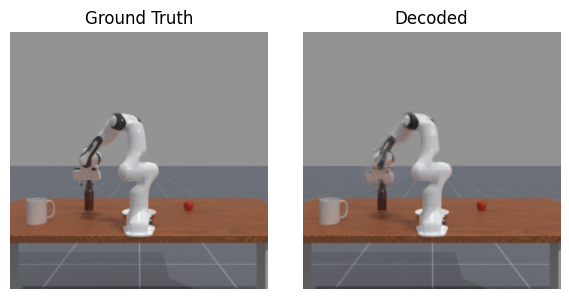

In [10]:
# GT → encode (V-JEPA AC) → decode → show (inline)
import numpy as np, torch, matplotlib.pyplot as plt
from PIL import Image

@torch.no_grad()
def show_gt_vs_recon(gt_img_uint8, encoder, decoder, device):
    """
    gt_img_uint8: np.ndarray [H, W, 3] uint8
    Displays GT (left) and Decoded (right) inline.
    """
    # to 256x256
    pil = Image.fromarray(gt_img_uint8.astype(np.uint8))
    if pil.size != (256, 256):
        pil = pil.resize((256, 256), resample=Image.Resampling.BILINEAR)

    # [1,3,256,256] in [0,1]
    x = torch.from_numpy(np.array(pil)).float().permute(2,0,1).unsqueeze(0) / 255.0

    # fake T=2 for AC encoder: [1,3,2,256,256]
    clip = x.unsqueeze(2).repeat(1,1,2,1,1).to(device, non_blocking=True)

    # encode → take last frame tokens
    tkns = encoder(clip)  # [1, 2*Ts^2, D]
    ps = getattr(encoder, "patch_size", 16)
    Ts2 = (256 // ps) * (256 // ps)
    z = tkns[:, -Ts2:, :]  # [1, Ts^2, D]

    # (optional) if your decoder/predictor expects normalized tokens:
    # z = torch.nn.functional.layer_norm(z, (z.size(-1),))

    # decode
    recon = decoder(z).clamp(0, 1).cpu()  # [1,3,256,256]

    # show inline
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(x[0].permute(1,2,0).cpu().numpy()); ax[0].set_title("Ground Truth"); ax[0].axis("off")
    ax[1].imshow(recon[0].permute(1,2,0).numpy());   ax[1].set_title("Decoded");      ax[1].axis("off")
    plt.tight_layout(); plt.show()


encoder.eval().to(device)
decoder.eval().to(device)

# e.g., img_t1 is your GT frame as uint8 H×W×3
show_gt_vs_recon(img_t1, encoder, decoder, device)


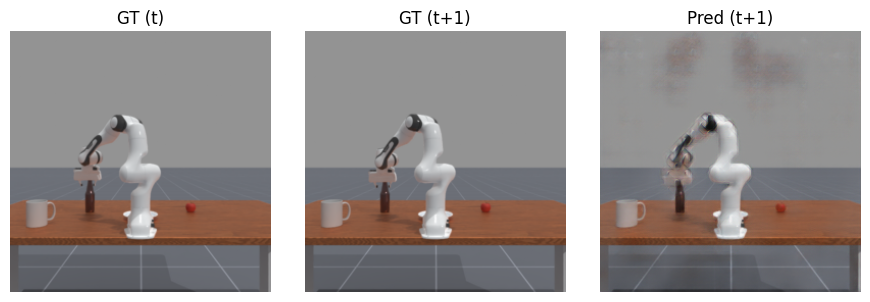

In [11]:
# --- Prediction demo: GT_t | GT_{t+1} | Predicted+Decoded_{t+1} ---
import numpy as np, torch, matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

@torch.no_grad()
def show_pred_triplet(frames, ee_7d_tensor, t, encoder, predictor, decoder, device, normalize_tokens=False):
    """
    Displays: GT_t (left), GT_{t+1} (middle), Predicted/Decoded_{t+1} (right)

    Inputs
    ------
    frames        : list-like of raw frames (each ~ (1,H,W,3) or (H,W,3) uint8)
    ee_7d_tensor  : torch.FloatTensor [T, 7] with [x,y,z, roll,pitch,yaw, gripper]
    t             : int, step index (must satisfy t < len(frames)-1)
    encoder       : V-JEPA AC encoder (expects T=2)
    predictor     : V-JEPA AC predictor
    decoder       : your TokenGridDecoder (embed_dim & tokens_side must match encoder)
    device        : torch.device
    normalize_tokens : bool, if True apply LayerNorm to tokens (match your training)
    """
    assert t < len(frames) - 1, "t must be < num_frames - 1"

    # ---- helpers ----
    def to_256_uint8(frame):
        arr = np.asarray(frame)
        if arr.ndim == 4 and arr.shape[0] == 1:  # handle (1,H,W,3)
            arr = arr[0]
        pil = Image.fromarray(arr.astype(np.uint8))
        if pil.size != (256, 256):
            pil = pil.resize((256, 256), resample=Image.Resampling.BILINEAR)
        return np.array(pil)

    def to_tensor_1x3x256x256(img_uint8):
        return torch.from_numpy(img_uint8).float().permute(2,0,1).unsqueeze(0) / 255.0

    # ---- prepare GT images ----
    gt_t_uint8  = to_256_uint8(frames[t])
    gt_t1_uint8 = to_256_uint8(frames[t+1])
    x_t  = to_tensor_1x3x256x256(gt_t_uint8)    # [1,3,256,256]
    x_t1 = to_tensor_1x3x256x256(gt_t1_uint8)   # [1,3,256,256]

    # ---- encode tokens for frame t (duplicate to fake T=2) ----
    clip_t = x_t.unsqueeze(2).repeat(1,1,2,1,1).to(device, non_blocking=True)  # [1,3,2,256,256]
    tkns_t = encoder(clip_t)                                                   # [1,2*Ts^2,D]
    ps   = getattr(encoder, "patch_size", 16)
    Ts2  = (256 // ps) * (256 // ps)
    z_t  = tkns_t[:, -Ts2:, :]                                                 # [1,Ts^2,D]
    if normalize_tokens:
        z_t = F.layer_norm(z_t, (z_t.size(-1),))

    # ---- action & state at time t ----
    s_t = ee_7d_tensor[t].to(device).view(1,1,-1)              # [1,1,7]
    a_t = (ee_7d_tensor[t+1] - ee_7d_tensor[t]).to(device).view(1,1,-1)  # [1,1,7]

    # ---- predict tokens for t+1 and decode ----
    z_next_pred = predictor(z_t, a_t, s_t)[:, -Ts2:, :]         # [1,Ts^2,D]
    if normalize_tokens:
        z_next_pred = F.layer_norm(z_next_pred, (z_next_pred.size(-1),))
    recon = decoder(z_next_pred).clamp(0, 1).cpu()              # [1,3,256,256]

    # ---- show inline: GT_t | GT_{t+1} | Pred+Dec ----
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].imshow(x_t[0].permute(1,2,0).cpu().numpy());   ax[0].set_title("GT (t)");        ax[0].axis("off")
    ax[1].imshow(x_t1[0].permute(1,2,0).cpu().numpy());  ax[1].set_title("GT (t+1)");      ax[1].axis("off")
    ax[2].imshow(recon[0].permute(1,2,0).numpy());       ax[2].set_title("Pred (t+1)");ax[2].axis("off")
    plt.tight_layout(); plt.show()

    return recon

encoder.eval().to(device)
predictor.eval().to(device)
decoder.eval().to(device)

t = 10
_ = show_pred_triplet(
    frames,
    ee7_t,   # ✅ not ee_7d
    t,
    encoder,
    predictor,
    decoder,
    device,
    normalize_tokens=False
)


## 8. Video Results 

In [12]:
from datetime import datetime
import os, math, numpy as np, torch, imageio
import torch.nn.functional as F
from torchvision.utils import make_grid
from PIL import Image

def _unique_writer(name, start_frame, fps, out_dir="videos", extra=None):
    os.makedirs(out_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    parts = [name]
    if extra: parts.append(str(extra))
    parts += [f"sf{start_frame}", ts]
    path = os.path.join(out_dir, "_".join(parts) + ".mp4")
    return imageio.get_writer(path, fps=fps), path

@torch.no_grad()
def _encode_image_tokens_256(img_uint8_256, encoder, device, normalize_tokens=True):
    """img_uint8_256: [256,256,3] uint8 -> tokens [1, Ts², D] (last-of-fake-2)"""
    x = torch.from_numpy(img_uint8_256).float().permute(2,0,1).unsqueeze(0) / 255.0   # [1,3,256,256]
    clip = x.unsqueeze(2).repeat(1,1,2,1,1).to(device, non_blocking=True)             # [1,3,2,256,256]
    h = encoder(clip)                                                                  # [1, 2*Ts², D]
    ps = getattr(encoder, "patch_size", 16)
    Ts2 = (256 // ps) * (256 // ps)
    z = h[:, -Ts2:, :]                                                                 # [1, Ts², D]
    if normalize_tokens:
        z = F.layer_norm(z, (z.size(-1),))
    return z

# ================================
# 1) Teacher-Forcing video (GT_t -> predict z_{t+1}, decode; compare to GT_{t+1})
# ================================
@torch.no_grad()
def make_teacher_forcing_video(frames,
                               ee_7d_tensor,
                               encoder, predictor, decoder, device,
                               start_frame=0, end_frame=None,
                               fps=5, normalize_tokens=True,
                               out_dir="videos", tag=None):
    """
    Produces: side-by-side GT_{t+1} | PredDecoded_{t+1}, conditioning on GT tokens at t.
    """
    # Precompute resized GT frames
    T = len(frames)
    if end_frame is None: end_frame = T - 1  # last usable t
    assert 0 <= start_frame < end_frame < T, "Invalid start/end"

    GT_256 = [resize_image(frames[t], (256,256)) for t in range(T)]

    # Precompute tokens for every GT frame (kept on CPU to save VRAM)
    Z_GT = [ _encode_image_tokens_256(GT_256[t], encoder, device, normalize_tokens).cpu()
             for t in range(T) ]

    writer, path = _unique_writer("tf_vs_gt", start_frame, fps, out_dir, tag)
    print(f"Writing TF video → {path}")

    lat_l1, cos_sims = [], []
    from utils.mpc_utils import compute_new_pose

    # start with GT state at start_frame
    s = ee_7d_tensor[start_frame].to(device).view(1,1,-1)

    for t in range(start_frame, end_frame):
        z_t = Z_GT[t].to(device, non_blocking=True)  # [1,Ts²,D]
        a_t = (ee_7d_tensor[t+1] - ee_7d_tensor[t]).to(device).view(1,1,-1)

        # predict next tokens
        z_next = predictor(z_t, a_t, s)[:, -z_t.shape[1]:]   # [1,Ts²,D]
        if normalize_tokens:
            z_next = F.layer_norm(z_next, (z_next.size(-1),))
        # update state
        s = compute_new_pose(s[:, -1:], a_t[:, -1:])         # [1,1,7]

        # metrics vs GT_{t+1}
        z_gt_next = Z_GT[t+1].to(device, non_blocking=True)
        lat_l1.append(torch.mean(torch.abs(z_next - z_gt_next)).item())
        cos_sims.append(F.cosine_similarity(z_next, z_gt_next, dim=-1).mean().item())

        # decode and write side-by-side
        pred_img = decoder(z_next).clamp(0,1).cpu()                       # [1,3,256,256]
        gt_tensor = (torch.from_numpy(GT_256[t+1]).float()
                        .permute(2,0,1).unsqueeze(0) / 255.0)             # [1,3,256,256]
        panel = make_grid([gt_tensor[0], pred_img[0]], nrow=2).permute(1,2,0).numpy()
        writer.append_data((panel * 255).astype(np.uint8))

    writer.close()
    print(f"✅ TF video saved: {path}")
    print(f"Avg latent L1: {np.mean(lat_l1):.4f} | Avg cosine: {np.mean(cos_sims):.4f}")
    return path

# ================================
# 2) Open-Loop video (predict repeatedly without GT tokens)
# ================================
@torch.no_grad()
def make_openloop_video(frames,
                        ee_7d_tensor,
                        encoder, predictor, decoder, device,
                        start_frame=0, end_frame=None,
                        fps=5, normalize_tokens=True,
                        out_dir="videos", tag=None):
    """
    Produces: side-by-side GT_{t+1} | PredDecoded_{t+1}, rolling predictions
    (no GT tokens after the start).
    """
    T = len(frames)
    if end_frame is None: end_frame = T - 1
    assert 0 <= start_frame < end_frame < T, "Invalid start/end"

    GT_256 = [resize_image(frames[t], (256,256)) for t in range(T)]
    writer, path = _unique_writer("openloop_vs_gt", start_frame, fps, out_dir, tag)
    print(f"Writing Open-Loop video → {path}")

    from utils.mpc_utils import compute_new_pose

    # Initial tokens: encode only the start frame (duplicate to fake T=2)
    z = _encode_image_tokens_256(GT_256[start_frame], encoder, device, normalize_tokens)  # [1,Ts²,D]
    s = ee_7d_tensor[start_frame].to(device).view(1,1,-1)                                 # [1,1,7]

    for t in range(start_frame, end_frame):
        a = (ee_7d_tensor[t+1] - ee_7d_tensor[t]).to(device).view(1,1,-1)

        # predict next tokens from previous prediction
        z = predictor(z, a, s)[:, -z.shape[1]:]     # [1,Ts²,D]
        if normalize_tokens:
            z = F.layer_norm(z, (z.size(-1),))
        # update state
        s = compute_new_pose(s[:, -1:], a[:, -1:])  # [1,1,7]

        # decode + side-by-side with GT_{t+1}
        pred_img = decoder(z).clamp(0,1).cpu()                     # [1,3,256,256]
        gt_tensor = (torch.from_numpy(GT_256[t+1]).float()
                        .permute(2,0,1).unsqueeze(0) / 255.0)      # [1,3,256,256]
        panel = make_grid([gt_tensor[0], pred_img[0]], nrow=2).permute(1,2,0).numpy()
        writer.append_data((panel * 255).astype(np.uint8))

    writer.close()
    print(f"✅ Open-Loop video saved: {path}")
    return path


In [13]:
# pick a window
sf = 15
ef = min(len(frames)-1, 200)   # e.g., first ~200 steps
fps = int(data["video"]["fps"]) if "data" in globals() else 4

In [14]:

# make both videos
tf_path  = make_teacher_forcing_video(frames, ee7_t, encoder, predictor, decoder,
                                      device, start_frame=sf, end_frame=ef, fps=fps,
                                      normalize_tokens=True, out_dir="videos")

print(tf_path)

Writing TF video → videos/tf_vs_gt_sf15_2025-09-09_10-43-35.mp4
[WARNING ][2025-09-09 10:43:35][imageio_ffmpeg      ][write_frames             ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (518, 260) to (528, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
✅ TF video saved: videos/tf_vs_gt_sf15_2025-09-09_10-43-35.mp4
Avg latent L1: 0.3711 | Avg cosine: 0.7766
videos/tf_vs_gt_sf15_2025-09-09_10-43-35.mp4


In [15]:
ol_path  = make_openloop_video(frames, ee7_t, encoder, predictor, decoder,
                               device, start_frame=sf, end_frame=ef, fps=fps,
                               normalize_tokens=True, out_dir="videos")

print(ol_path)

Writing Open-Loop video → videos/openloop_vs_gt_sf15_2025-09-09_10-43-38.mp4
[WARNING ][2025-09-09 10:43:38][imageio_ffmpeg      ][write_frames             ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (518, 260) to (528, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
✅ Open-Loop video saved: videos/openloop_vs_gt_sf15_2025-09-09_10-43-38.mp4
videos/openloop_vs_gt_sf15_2025-09-09_10-43-38.mp4


## Droid decoder with teacher forcing and open-loop prediction

In [32]:
# Evaluate a trained decoder on a single continuous DROID-100 episode.
# - Teacher-forcing: GT_t -> encode -> decode (frame-by-frame)
# - Open-loop feedback: rec_{k+1} = dec(enc(rec_k)) starting from GT_0

import os, math, numpy as np, tensorflow as tf, imageio
from pathlib import Path
from datetime import datetime
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

# ---------------- edit these ----------------
DROID_ROOT   = "/data/maddie/vjepa2/droid/droid_100"   # folder containing "1.0.0/"
CAMERA_KEY   = "exterior_image_1_left"                 # use a key you saw in dataset
DECODER_CKPT = "/data/maddie/vjepa2/decoder/checkpoints/droid_origdec_2025-09-09_11-16-25/epoch_1.pth"  # y   # <- your trained weights
FPS_DISPLAY  = 4                                       # just for the saved mp4
# --------------------------------------------

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ----------------------------------------------------
# 1) Load ONE continuous episode (all frames in order)
# ----------------------------------------------------
def load_one_episode(root, camera=CAMERA_KEY, resize_to=(256,256)):
    """
    Return: list of HxWx3 uint8 frames (already resized to 256x256).
    We pick the first Example that has >= 3 frames for the given camera.
    """
    files = sorted((Path(root) / "1.0.0").glob("*.tfrecord*"))
    if not files:
        raise FileNotFoundError(f"No TFRecords under {root}/1.0.0")

    ds = tf.data.TFRecordDataset([str(f) for f in files])
    key = f"steps/observation/{camera}"
    spec = {key: tf.io.VarLenFeature(tf.string)}

    for raw in ds:
        ex = tf.io.parse_single_example(raw, spec)
        bytes_vec = tf.sparse.to_dense(ex[key])
        frames = [tf.io.decode_jpeg(b, channels=3).numpy() for b in bytes_vec]

        if len(frames) >= 3:
            # resize all to 256x256
            out = []
            for f in frames:
                pil = Image.fromarray(f)
                if pil.size != resize_to:
                    pil = pil.resize(resize_to, resample=Image.Resampling.BILINEAR)
                out.append(np.array(pil))
            return out

    raise RuntimeError("No example with >=3 frames for this camera.")

# ----------------------------------------------------
# 2) V-JEPA AC encoder helper (last-of-fake-2 tokens)
# ----------------------------------------------------
@torch.no_grad()
def encode_tokens_256(img_uint8, encoder):
    """
    img_uint8: [256,256,3] uint8 -> tokens [1, Ts², D] (no LayerNorm).
    Matches how your decoder was trained.
    """
    x = torch.from_numpy(img_uint8).float().permute(2,0,1).unsqueeze(0) / 255.0  # [1,3,256,256]
    clip = x.unsqueeze(2).repeat(1,1,2,1,1).to(DEVICE)                           # [1,3,2,256,256]
    tkns = encoder(clip)                                                          # [1,2*Ts²,D]
    ps = getattr(encoder, "patch_size", 16)
    Ts2 = (256//ps) * (256//ps)
    return tkns[:, -Ts2:, :]                                                      # [1,Ts²,D]

# ----------------------------------------------------
# 3) Your decoder (same arch as you trained)
# ----------------------------------------------------
class TokenDecoder(nn.Module):
    def __init__(self, embed_dim, tokens_side, out_res=256, base_ch=2048):
        super().__init__()
        self.proj = nn.Conv2d(embed_dim, base_ch, kernel_size=1)
        layers, ch = [], base_ch
        steps = int(np.log2(out_res // tokens_side))  # e.g., 16->32->...->256
        for _ in range(steps):
            nxt = ch // 2
            groups = 8 if nxt % 8 == 0 else max(1, nxt // 8)
            layers += [nn.ConvTranspose2d(ch, nxt, 4, 2, 1),
                       nn.GroupNorm(groups, nxt),
                       nn.ReLU(inplace=True)]
            ch = nxt
        layers += [nn.Conv2d(ch, 3, 3, 1, 1), nn.Sigmoid()]
        self.up = nn.Sequential(*layers)

    def forward(self, tokens):                        # [B,N,D]
        B, N, D = tokens.shape
        S = int(math.sqrt(N)); assert S*S == N
        z = tokens.transpose(1,2).reshape(B, D, S, S) # [B,D,S,S]
        return self.up(self.proj(z))                  # [B,3,256,256]

# ----------------------------------------------------
# 4) Videos
# ----------------------------------------------------
def unique_writer(name, fps=FPS_DISPLAY, tag=None, out_dir="videos"):
    os.makedirs(out_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    fname = f"{name}{'_'+tag if tag else ''}_{ts}.mp4"
    path = os.path.join(out_dir, fname)
    return imageio.get_writer(path, fps=fps), path

@torch.no_grad()
def make_teacher_forcing_video(frames_256, encoder, decoder, tag=None):
    w, path = unique_writer("tf_vs_gt", tag=tag)
    for img in frames_256:
        z   = encode_tokens_256(img, encoder)      # [1,Ts²,D]
        rec = decoder(z).clamp(0,1).cpu()[0]       # [3,256,256]
        gt  = torch.from_numpy(img).float().permute(2,0,1)/255.0
        panel = make_grid([gt, rec], nrow=2).permute(1,2,0).numpy()
        w.append_data((panel*255).astype(np.uint8))
    w.close()
    print(f"✅ TF video → {path}")
    return path

@torch.no_grad()
def make_openloop_feedback_video(frames_256, encoder, decoder, steps=None, tag=None):
    """
    Decoder-only stability: rec_0 = dec(enc(GT_0));
    rec_{k+1} = dec(enc(rec_k)).
    """
    w, path = unique_writer("openloop_feedback", tag=tag)
    T = len(frames_256)
    K = steps if steps is not None else T-1

    # init with GT_0
    z   = encode_tokens_256(frames_256[0], encoder)
    rec = decoder(z).clamp(0,1).cpu()  # [1,3,256,256]

    for k in range(K):
        gt_k = torch.from_numpy(frames_256[min(k, T-1)]).float().permute(2,0,1)/255.0
        panel = make_grid([gt_k, rec[0]], nrow=2).permute(1,2,0).numpy()
        w.append_data((panel*255).astype(np.uint8))

        # feedback
        z   = encode_tokens_256((rec[0]*255).permute(1,2,0).numpy().astype(np.uint8), encoder)
        rec = decoder(z).clamp(0,1).cpu()

    w.close()
    print(f"✅ Open-loop feedback video → {path}")
    return path

# ----------------------------------------------------
# 5) Run
# ----------------------------------------------------
if __name__ == "__main__":
    # Episode
    episode = load_one_episode(DROID_ROOT, camera=CAMERA_KEY)
    print(f"Episode length: {len(episode)} frames")

    # Encoder
    encoder, _ = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
    encoder = encoder.to(DEVICE).eval()
    ps = encoder.patch_size
    tokens_side = 256 // ps
    print(f"Encoder patch={ps}, tokens/side={tokens_side}")

    # Decoder
    decoder = TokenDecoder(embed_dim=encoder.embed_dim, tokens_side=tokens_side).to(DEVICE).eval()
    if os.path.isfile(DECODER_CKPT):
        decoder.load_state_dict(torch.load(DECODER_CKPT, map_location=DEVICE), strict=True)
        print("Loaded decoder weights:", DECODER_CKPT)
    else:
        print("[warn] DECODER_CKPT not found; running with random weights.")

    # Videos
    tag = "droid100_ep0"
    tf_path = make_teacher_forcing_video(episode, encoder, decoder, tag=tag)
    ol_path = make_openloop_feedback_video(episode, encoder, decoder, steps=min(200, len(episode)*2), tag=tag)
    print("\nSaved:")
    print("  TF       →", tf_path)
    print("  OpenLoop →", ol_path)


Device: cuda
Episode length: 166 frames


Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main


Encoder patch=16, tokens/side=16
Loaded decoder weights: /data/maddie/vjepa2/decoder/checkpoints/droid_origdec_2025-09-09_11-16-25/epoch_1.pth
[WARNING ][2025-09-09 12:06:01][imageio_ffmpeg      ][write_frames             ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (518, 260) to (528, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
✅ TF video → videos/tf_vs_gt_droid100_ep0_2025-09-09_12-06-00.mp4
[WARNING ][2025-09-09 12:06:15][imageio_ffmpeg      ][write_frames             ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (518, 260) to (528, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompa